In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
random.seed(42)

# AM207 final project: Uncertainty modeling

The paper we chose is [what-uncertainties-do-we-need](https://papers.nips.cc/paper/7141-what-uncertainties-do-we-need-in-bayesian-deep-learning-for-computer-vision.pdf)
> what uncertainties do we need in Bayesian Neural Network?

The notebook is structured as

- Background
- A pedigogical example: Neural Network with `cos`
- discussion for the results

## Background

There are two types of uncertainties in any machine learning task. The first is epistemic uncertainty - which is **aleatoric uncertainty** associated with observation e.g. image occulsion; and **epistemic uncertainty** associated with model that can be reduced given enough data.

Bayesian Neural Network aims to find posterior which is $P(W|D)=\frac{P(D|W)P(W)}{P(D)}$ However $P(D)$ part is very hard - we will hardly get the true distribution of data. However Monte-Carlo samples could help us approximate $P(W|D)$ by applying dropout. 

The paper proposed that we can model epistemic uncertainty along, aleatoric uncertainty along and both together, since aleatoric uncertainty can be learnd as learned loss attentuation - making loss more robust to noisy data.


## Minimal regression example

Here we devised a simple neural network with dropout that gives both predicted y and a noise term $\log\sigma^2$. We use a very simple design of neural network - four consecutive fully connected layers of `hidden_size`. We used `ReLU` as activation function and used dropout at every layer. `Dropout` is preserved as a MC sampling regime - we apply dropout at both testing and training time, therefore we could approximate a MC sampling approach. 

For this example, first we will generate training and testing data by `gen_data`. The form of any neural network can be presented as 
$$
Y = f_w(X) + \sigma(X)
$$

Therefore we designed `mean_fun` for $f_w(X)$ and `std_fun` for $\sigma(X)$. The additional params are `hetero` and `occulude` - the first refers to adding heteroskedestic erorr - $\epsilon \sim N(0, \sigma(x_i))$ rather than constant variance $\epsilon \sim N(0, \sigma)$. `occlude` signfies if we engineer a region (a quarter of values) to be empty.

In [2]:
def gen_data(mean_fun, std_fun, hetero = True, occlude = True, train_abs=2, test_abs=5):
    """
    mean_fun and std_fun: two normal function to 
    engineer relatinship y = f_w(x) + sigma(x)
    # please keep std_fun larger than zero
    
    train/test abs are the absolute value of x ranges
    
    return two sets of tensor pairs
    """
    # test data as ground truth
    test_vec_size = int(500)
    x_test = np.linspace(-test_abs, test_abs, test_vec_size)
    y_test = mean_fun(x_test)
    
    # train data with some problem
    train_vec_size = int(test_vec_size * 0.5)
    x_train = np.linspace(-train_abs, train_abs, train_vec_size)
    y_train = mean_fun(x_train)
    
    plot_title = "data:"
    if hetero:
        plot_title = plot_title + " heteroskedastic"
        noise = np.random.normal(0, np.abs(std_fun(x_train)), train_vec_size)
        y_train = y_train + noise
    else:
        y_train = y_train + np.random.normal(0, 0.1, train_vec_size)
    
    if occlude:
        plot_title = plot_title + " occlusion"
        indicies = np.arange(train_vec_size)
        n_piece = indicies//(train_vec_size/4)
        new_indicies = np.concatenate((indicies[n_piece != 1], indicies[n_piece == 1][1::5]), axis=None)
        y_train = y_train[new_indicies]
        x_train = x_train[new_indicies]
    
    # plot
    plt.figure(figsize=(12, 4))
    plt.scatter(x_test, y_test, c="orange",s=7, label = "test")
    plt.scatter(x_train, y_train, s=7, label = "train")
    plt.legend()
    plt.title(plot_title)
    
    # turn all array into tensors
    x_train = torch.from_numpy(x_train).float().view(-1, 1)
    y_train = torch.from_numpy(y_train).float().view(-1, 1)
    x_test = torch.from_numpy(x_test).float().view(-1, 1)
    y_test = torch.from_numpy(y_test).float().view(-1, 1)
    
    return(x_train, y_train, x_test, y_test)

In [3]:
class Net(torch.nn.Module):
    def __init__(self, p, logvar, n_feature, n_hidden, n_output):
        super().__init__()
        self.p = p
        self.logvar = logvar
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.mid1 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.mid2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.mid3 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.mid4 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer

        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.get_var = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.mid1(x))      # activation function for hidden layer
        x = F.relu(self.mid2(x))
        x = F.relu(self.mid3(x))
        x = F.relu(self.mid4(x))
        
        x = F.dropout(x, p = self.p)
        
        # get y and log_sigma
        y = self.predict(x)
        if self.logvar:
            logvar = self.get_var(x)
        else:
            logvar = torch.zeros(y.size()) 
        return y, logvar

class aleatoric_loss(nn.Module):
    def __init__(self):
        super(aleatoric_loss, self).__init__()
    def forward(self, gt, pred_y, logvar):
        loss = torch.sum(0.5*(torch.exp((-1)*logvar)) * (gt - pred_y)**2 + 0.5*logvar)
        return loss

def train_model(network, loss_function, X, y, 
                number_epochs=1000, learning_rate = 1e-4, weight_decay=0.001):
    """
    network: an instance of the Net Class
    loss function: an instance of loss Class
    opt: an instance of optimizer class
    """
    optimizer = optim.Adam(network.parameters(), 
                           lr=learning_rate, 
                           weight_decay=weight_decay)
#     plt.ion()
    for t in range(number_epochs):
        prediction, log_var = network(X)

        loss = loss_function(y, prediction, log_var)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

    return network

def get_MC_samples(network, X, dropout = True, mc_times=64):
    pred_v = []; a_u = []

    for t in range(mc_times):
        if dropout:
            prediction, var = network(X)
        else:
            network.eval()
            prediction, var = network(X)

        pred_v.append(prediction.data.numpy())
        a_u.append(var.data.numpy())

    pred_v = np.array(pred_v); a_u = np.array(a_u)
    a_u = np.sqrt(np.exp(np.mean(a_u, axis=0)))
    pred_mean = np.mean(pred_v, axis=0)
    e_u = np.sqrt(np.var(pred_v, axis=0))
    return pred_mean.squeeze(), a_u.squeeze(), e_u.squeeze()

def view_uncertainty(fig_title, pred_val, ale_val, epi_val, x_train, y_train, x_test, y_test):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,4))
    for ax in axs:
        ax.scatter(x_test, y_test, c="orange",s=7, label = "test")
        ax.scatter(x_train, y_train, s=7, label = "train")
        ax.plot(x_test, pred_val,c="red", label = "predict")
    
    if np.mean(ale_val) != 1:
        axs[0].fill_between(x_test.squeeze(), pred_val-ale_val, pred_val+ale_val, 
                         label = "Aleatoric")
    if np.sum(epi_val) != 0:
        axs[1].fill_between(x_test.squeeze(), pred_val-epi_val, pred_val+epi_val,
                         label = "Epistemic")
    axs[0].legend(); axs[1].legend()
    fig.suptitle(fig_title)
    plt.show()
    
def viz_uncertainty(if_drop, if_ale, fig_title, default_p=0.5):
    if not if_drop:
        p = 0
    else: 
        p = default_p
    net = Net(p, if_ale, *NET_STRUCTURE)
    net = train_model(net, LOSS, *DATASET[0:2], **TRAIN_PARAMS)
    args = get_MC_samples(net, DATASET[2], dropout = if_drop)
    view_uncertainty(fig_title, *args, *DATASET)
    return(net)

To make better benchmark, we used identical parameters for all neural networks, the network structure has four full connected layers, each with 32 hidden nodes. We will train NN by 2000 epochs using Adam optimizer with LR=1e-4 and 0.001 weight decay.

In [4]:
NET_STRUCTURE = [1, 32, 1]
TRAIN_PARAMS=dict(number_epochs=2000, learning_rate = 1e-4, weight_decay=0.001)
LOSS = aleatoric_loss() 

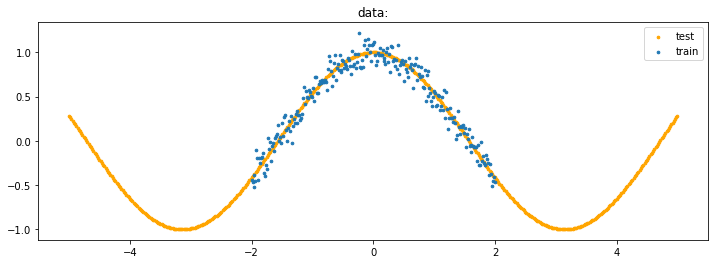

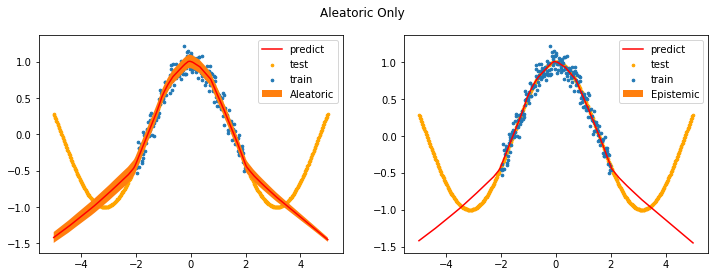

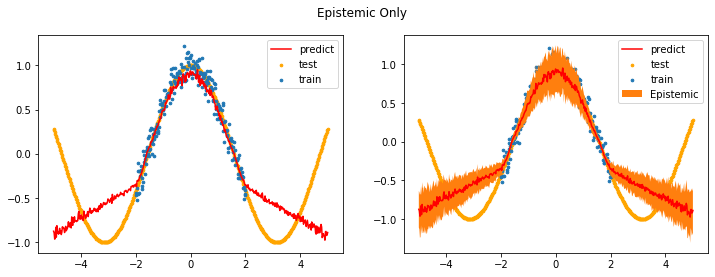

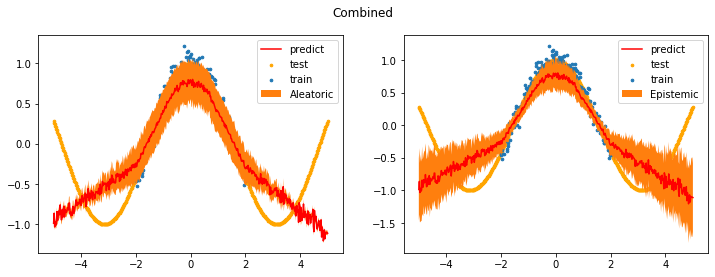

In [5]:
DATASET = gen_data(np.cos, lambda x: 0.3*x, False, False)
# three types of models
_ = viz_uncertainty(False, True, "Aleatoric Only")
_ = viz_uncertainty(True, False, "Epistemic Only")
_ = viz_uncertainty(True, True, "Combined")

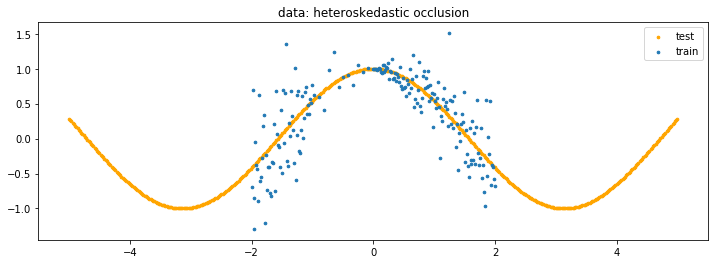

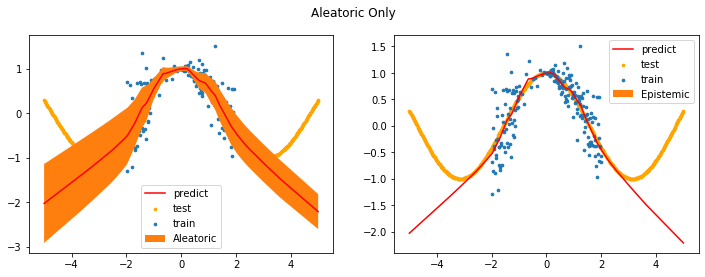

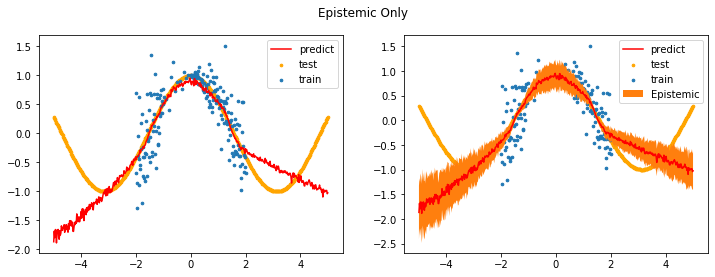

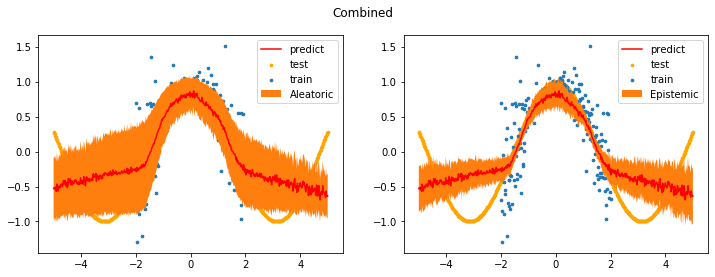

In [6]:
DATASET = gen_data(np.cos, lambda x: 0.3*x, True, True)
# three types of models
_ = viz_uncertainty(False, True, "Aleatoric Only")
_ = viz_uncertainty(True, False, "Epistemic Only")
_ = viz_uncertainty(True, True, "Combined")

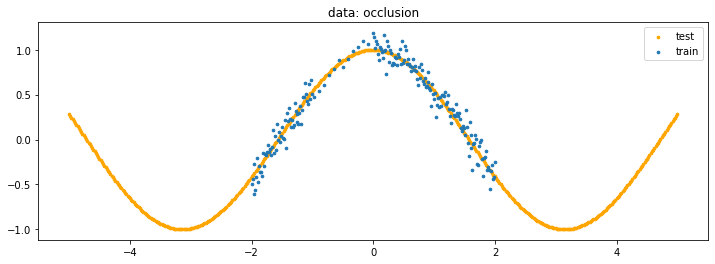

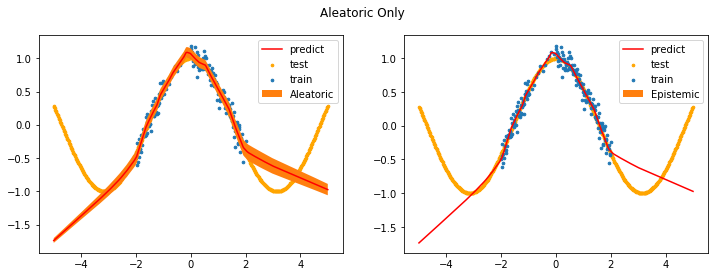

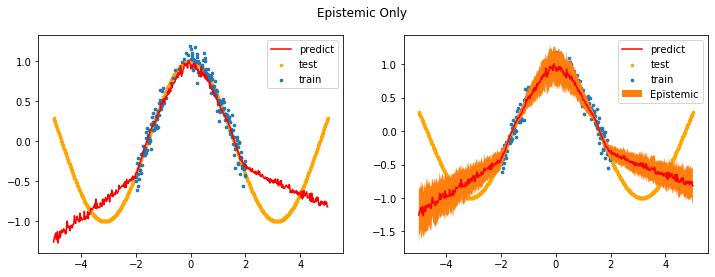

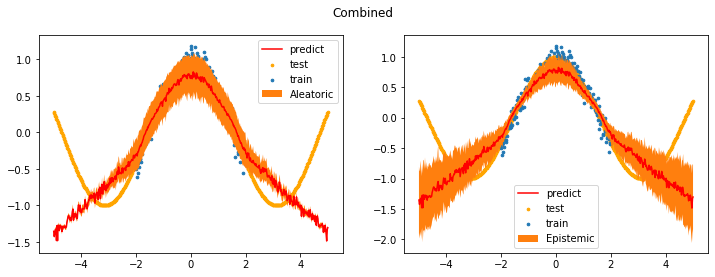

In [7]:
DATASET = gen_data(np.cos, lambda x: 0.3*x, False, True)
# three types of models
_ = viz_uncertainty(False, True, "Aleatoric Only")
_ = viz_uncertainty(True, False, "Epistemic Only")
_ = viz_uncertainty(True, True, "Combined")

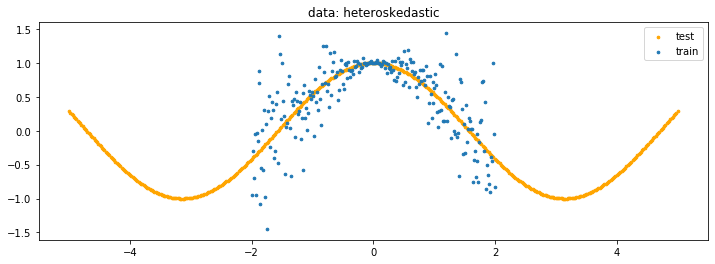

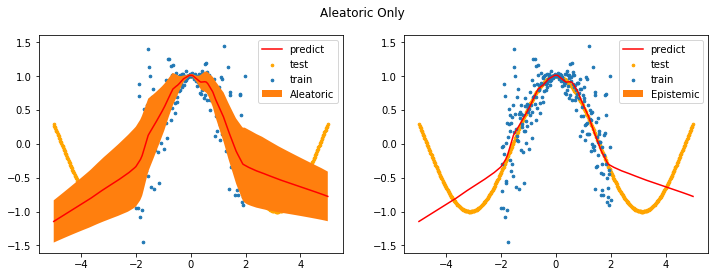

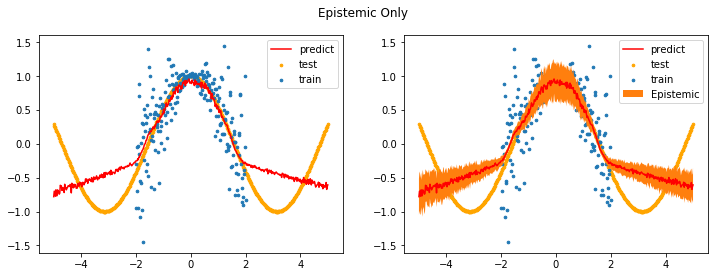

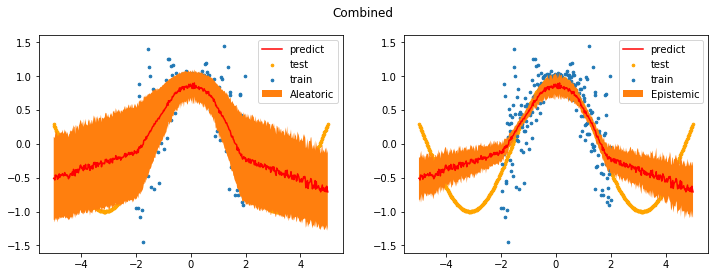

In [8]:
DATASET = gen_data(np.cos, lambda x: 0.3*x, True, False)
# three types of models
_ = viz_uncertainty(False, True, "Aleatoric Only")
_ = viz_uncertainty(True, False, "Epistemic Only")
_ = viz_uncertainty(True, True, "Combined")